# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs

In [5]:
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'

MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA_GLIDER_2024/"

XML_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/XML/glider_nettab_per_dive.xml'

QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'


# Extraindo informações dos arquivos ".mseed"

In [6]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/GL.*'))

In [7]:
len(filenames_MSEED)

1639

In [8]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[-1].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [9]:
pandas_mseed_lst = []

with Pool(processes=12) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|███████████████████████████████████████| 1639/1639 [03:21<00:00,  8.12it/s]


In [10]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [11]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime,format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final.sort_values('starttime')


,filename,starttime,endtime
11,GL.G1500..HHH.D.2015.316,2015-11-12 13:48:41,2015-11-12 23:59:59.990
8,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930
7,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930
12,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930
4,GL.G1500..HHH.D.2015.320,2015-11-16 00:11:21,2015-11-16 21:54:52.930
...,...,...,...
1635,GL.G211E..HHH.D.2021.304,2021-10-31 00:18:55,2021-10-31 14:31:12.270
1636,GL.G211E..HHH.D.2021.305,2021-11-01 05:11:58,2021-11-01 13:30:59.780
1637,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010
1638,GL.G211E..HHH.D.2021.307,2021-11-03 03:38:04,2021-11-03 11:50:10.980


# Extraindo informações do Inventório ".xml"

In [12]:
inv_glider = read_inventory(XML_FILE)

In [13]:
inv_glider

Inventory created at 2024-04-26T14:41:30.100914Z
	Sending institution: scxml import (ObsPy Inventory)
	Contains:
		Networks (1):
			GL
		Stations (45):
			GL.G1500 (RSBR-MAR Station C00:SG618)
			GL.G1601 (RSBR-MAR Station C01:SG618)
			GL.G1602 (RSBR-MAR Station C02:SG612)
			GL.G1604 (RSBR-MAR Station C04:SG612)
			GL.G1605 (RSBR-MAR Station C05:SG612)
			GL.G1606 (RSBR-MAR Station C06:SG612)
			GL.G1607 (RSBR-MAR Station C07:SG612)
			GL.G1608 (RSBR-MAR Station C08:SG612)
			GL.G1709 (RSBR-MAR Station C09:SG612)
			GL.G170A (RSBR-MAR Station C10:SG569)
			GL.G170B (RSBR-MAR Station C11:SG570)
			GL.G170C (RSBR-MAR Station C12:SG569)
			GL.G170E (RSBR-MAR Station C14:SG571)
			GL.G170F (RSBR-MAR Station C15:SG612)
			GL.G170G (RSBR-MAR Station C16:SG612)
			GL.G170H (RSBR-MAR Station C17:SG612)
			GL.G170I (RSBR-MAR Station C18:SG571)
			GL.G170J (RSBR-MAR Station C19:SG612)
			GL.G180K (RSBR-MAR Station C20:SG612)
			GL.G180L (RSBR-MAR Station C21:SG612)
			GL.G180M (RSBR-MAR Statio

In [14]:
df_glider_xml_lst = []
for sta in inv_glider[0]:
    for cha in sta:
        station = sta.code
        latitude = cha.latitude
        longitude = cha.longitude
        depth = cha.depth*(-1)
        starttime = cha.start_date
        endtime = cha.end_date
        df_cha = pd.DataFrame([[station],[latitude],[longitude],[depth],[starttime],[endtime]], index=['station','latitude','longitude','depth','starttime','endtime']).T
        df_glider_xml_lst.append(df_cha)

In [15]:
dataframe_glider_xml = pd.concat(df_glider_xml_lst, ignore_index=True)

In [16]:
dataframe_glider_xml

,station,latitude,longitude,depth,starttime,endtime
0,G1500,-23.8244,-42.4954,-25.43,2015-11-12T13:48:00.000000Z,2015-11-12T13:56:00.000000Z
1,G1500,-23.8166,-42.4944,-49.85,2015-11-12T14:36:00.000000Z,2015-11-12T14:50:00.000000Z
2,G1500,-23.8071,-42.4872,-151.93,2015-11-12T15:35:00.000000Z,2015-11-12T16:15:00.000000Z
3,G1500,-23.7909,-42.4733,-252.44,2015-11-12T17:42:00.000000Z,2015-11-12T18:43:00.000000Z
4,G1500,-23.7852,-42.469,-256.76,2015-11-12T20:43:00.000000Z,2015-11-12T21:47:00.000000Z
...,...,...,...,...,...,...
3772,G211E,-24.3342,-42.434,-472.7,2021-11-02T12:40:00.000000Z,2021-11-02T15:18:00.000000Z
3773,G211E,-24.3568,-42.4256,-480.42,2021-11-03T03:38:00.000000Z,2021-11-03T06:09:00.000000Z
3774,G211E,-24.3784,-42.4306,-477.73,2021-11-03T09:16:00.000000Z,2021-11-03T11:50:00.000000Z
3775,G211E,-24.4377,-42.4649,-434.74,2021-11-04T00:25:00.000000Z,2021-11-04T02:19:00.000000Z


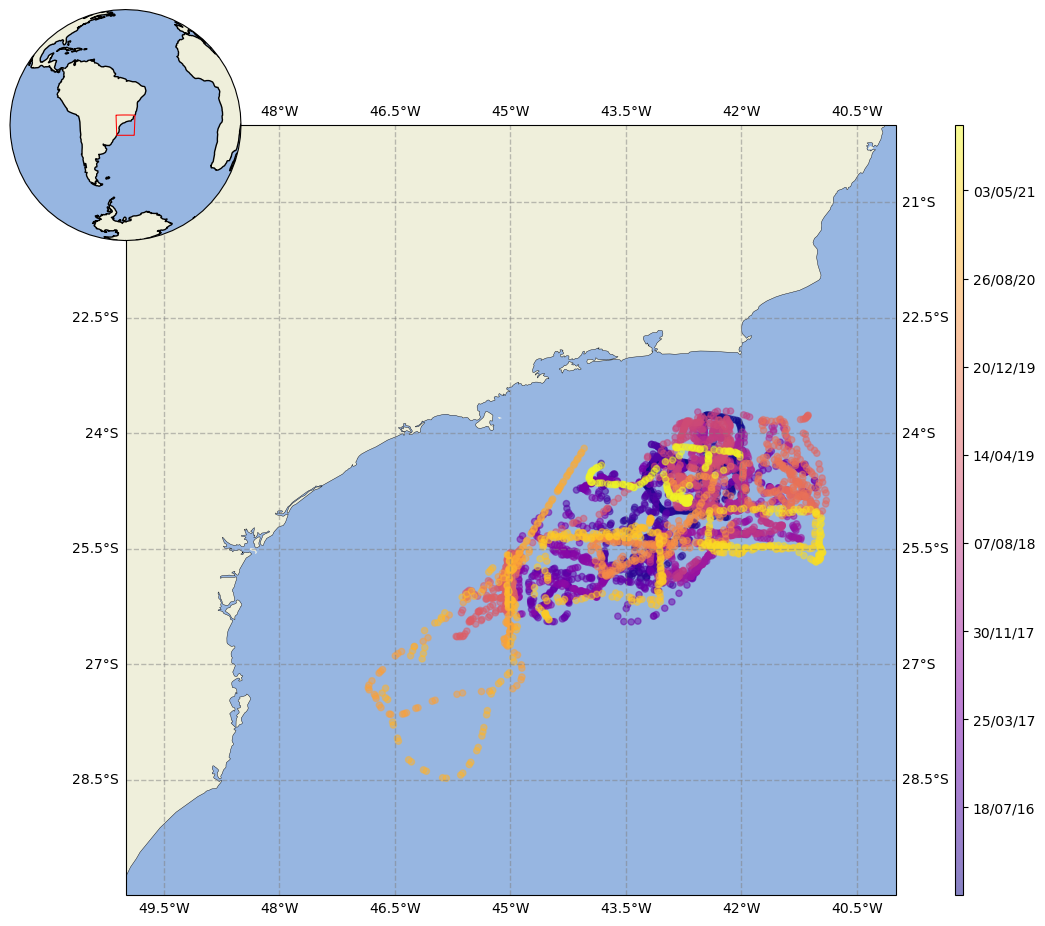

In [17]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=20,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Coletando terremotos que tenham mecanismo focal calculado do CMT:

In [40]:
print ('Global CMT solutions downloader from IRIS.edu database')
print ('© Foivos Karakostas - INGV Bologna, 2022')
print ('- - - - - - - - - - - - - - - - - - - - - - - - - - - -')
print (' ')
#link = https://github.com/foivoskar/pyGCMT/blob/main/pyGCMT-example.ipynb

starttime = UTCDateTime("2015-11-01T00:00:00")
endtime = UTCDateTime("2021-12-31T23:59:59")

minlat = -90
maxlat = 90
minlon = -180
maxlon = 180
minmag = 6
maxmag = 9.9

c_fdsn = Client('IRIS')
cat = c_fdsn.get_events(minlatitude = minlat, maxlatitude = maxlat, minlongitude = minlon, maxlongitude = maxlon, minmagnitude=minmag, maxmagnitude=maxmag, starttime = starttime, endtime = endtime, includeallorigins=True)

print (' ')
print (str(len(cat)), ' event(s) found')
print (' ')

ns = {"q":"http://quakeml.org/xmlns/quakeml/1.2",
       "d":"http://quakeml.org/xmlns/bed/1.2",
        "catalog":"http://anss.org/xmlns/catalog/0.1",
        "tensor":"http://anss.org/xmlns/tensor/0.1"}
line01 = []; line02 = []; line03 = []; line04 = []; line05 = []; line06 = []; line07 = []; line08 = []; line09 = []
line10 = []; line11 = []; line12 = []; line13 = []; failed = 0; successful = 0

os.makedirs(QUAKEXML_FOLDER,exist_ok=True)
filename = QUAKEXML_FOLDER+'CMTSOLUTIONS'

for e in range(0, len(cat)):
    eventtime = UTCDateTime(cat[e].origins[0].time)
    url = ('http://ds.iris.edu/spudservice/momenttensor/gcmtid/C' + str(eventtime.year).zfill(4) + str(eventtime.month).zfill(2) + str(eventtime.day).zfill(2) + str(eventtime.hour).zfill(2) + str(eventtime.minute).zfill(2) +'A/quakeml')
    r = requests.get(url, allow_redirects=True)
    r.raw.decode_content = True
    local_file = 'temp.xml'
    with open(local_file, 'wb')as file:
        file.write(r.content)  
    with open('temp.xml', 'r') as file :
        filedata = file.read()
        filedata = filedata.replace('&lt;', '<'); filedata = filedata.replace('&gt;', '>')
        filedata = filedata.replace('<pre>', ''); filedata = filedata.replace('<body>', '')
        filedata = filedata.replace('<html>', ''); filedata = filedata.replace('</pre>', '')
        filedata = filedata.replace('</body>', ''); filedata = filedata.replace('</html>', '')
    with open('temp.xml', 'w') as file:
        file.write(filedata)
    filetemp = open('temp.xml', 'r')
    Lines = filetemp.readlines()
    line2test = str(Lines[0])
    testline = line2test[0:9]
    if testline == 'Error 400':
        failed = failed + 1
        print('Processed successfully ',str("{:.0f}".format(successful).rjust(5)),' event(s) and ', str("{:.0f}".format(failed).rjust(5)),' event(s) failed - TOTAL: ', str("{:.0f}".format(e+1).rjust(5)), 'events or ', str("{:.2f}".format(((e+1)/len(cat))*100).rjust(6)), '% done', end='\r')
        #time.sleep(1)
    else:
        successful = successful + 1
        print('Processed successfully ',str("{:.0f}".format(successful).rjust(5)),' event(s) and ', str("{:.0f}".format(failed).rjust(5)),' event(s) failed - TOTAL: ', str("{:.0f}".format(e+1).rjust(5)), 'events or ', str("{:.2f}".format(((e+1)/len(cat))*100).rjust(6)), '% done', end='\r')
        #time.sleep(1)
        tree = ET.parse('temp.xml')
        root = tree.getroot()
        eventlist = root.findall('d:eventParameters',ns)
        cat2 = read_events('temp.xml','quakeml')
        Mwc = 0
        Mb = 0
        Magnitudes = cat2[0].magnitudes
        Magtype = []
        for o in range(0, len(Magnitudes)):
            Magtype.append(Magnitudes[o].magnitude_type)
            if Magtype[o] == 'Mwc':
                Mwc = Magnitudes[o].mag;
            if Magtype[o] == 'Mb':
                Mb = Magnitudes[o].mag;
        eventtime = cat2[0].origins[0].time;
        strmicro = str(eventtime.microsecond);
        line01.append(' PDEQ ' + str(eventtime.year).rjust(4) + ' ' + str(eventtime.month).rjust(2) + ' ' + str(eventtime.day).rjust(2) + ' ' + str(eventtime.hour).rjust(2) + ' ' + str(eventtime.minute).rjust(2) + ' ' + str(eventtime.second).rjust(2) + '.' + strmicro[0:2] + ' ' + str("{:-.4f}".format(cat2[0].origins[0].latitude)).rjust(8) + ' ' + str("{:-.4f}".format(cat2[0].origins[0].longitude)).rjust(8) + ' ' + str(cat2[0].origins[1].depth/1000) + '  ' + str("{:-.1f}".format(Mb)).rjust(3) + '  ' + str("{:-.1f}".format(Mwc)).rjust(3) + ' ' + cat2[0].event_descriptions[0].text)    
        enam = str(cat2[0].origins[0].resource_id)
        line02.append('event name:      ' + enam[50:-10])   
        # Find the time shift
        correctedtime = cat2[0].origins[1].time;
        timeshift = correctedtime - eventtime
        line03.append('time shift:      ' + str("{:.4f}".format(timeshift)).rjust(7))
        line04.append('half duration:   ' + str("{:.4f}".format(cat2[0].focal_mechanisms[0].moment_tensor.source_time_function.duration/2)).rjust(7))
        line05.append('latitude:       ' + str("{:-.4f}".format(cat2[0].origins[1].latitude)).rjust(8))
        line06.append('longitude:      ' + str("{:-.4f}".format(cat2[0].origins[1].longitude)).rjust(8))
        line07.append('depth:          ' + str("{:.4f}".format(cat2[0].origins[1].depth/1000)).rjust(8))
        line08.append('Mrr:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rr*1e7)).rjust(13))
        line09.append('Mtt:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_tt*1e7)).rjust(13))
        line10.append('Mpp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_pp*1e7)).rjust(13))
        line11.append('Mrt:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rt*1e7)).rjust(13))
        line12.append('Mrp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rp*1e7)).rjust(13))
        line13.append('Mtp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_tp*1e7)).rjust(13))
with open(filename, 'w') as f:
    for tt in range(0, len(line01)):
        f.write(line01[tt]); f.write('\n'); f.write(line02[tt]); f.write('\n'); f.write(line03[tt]); f.write('\n')
        f.write(line04[tt]); f.write('\n'); f.write(line05[tt]); f.write('\n'); f.write(line06[tt]); f.write('\n')
        f.write(line07[tt]); f.write('\n'); f.write(line08[tt]); f.write('\n'); f.write(line09[tt]); f.write('\n')
        f.write(line10[tt]); f.write('\n'); f.write(line11[tt]); f.write('\n'); f.write(line12[tt]); f.write('\n')
        f.write(line13[tt]); f.write('\n'); f.write('\n')    
print ('\n', end = '\n')
print ('The CMT catalog is ready, it is stored in the `CMTSOLUTIONS` file')

Global CMT solutions downloader from IRIS.edu database
© Foivos Karakostas - INGV Bologna, 2022
- - - - - - - - - - - - - - - - - - - - - - - - - - - -
 
 
832  event(s) found
 
Processed successfully    781  event(s) and     51  event(s) failed - TOTAL:    832 events or  100.00 % done

The CMT catalog is ready, it is stored in the `CMTSOLUTIONS` file


In [18]:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS')
cat

781 Event(s) in Catalog:
2021-12-29T18:26:00.000000Z |  -7.690, +127.560 | 7.32 mw
2021-12-26T15:43:01.700000Z | -18.060, -179.360 | 6.14 mw
...
2015-11-07T07:04:41.800000Z | -29.540,  -72.330 | 6.05 mw
2015-11-04T03:44:21.200000Z |  -8.200, +124.950 | 6.54 mw
To see all events call 'print(CatalogObject.__str__(print_all=True))'

# PROCURANDO EVENTOS EM FUNÇÃO DO CATÁLOGO 

In [19]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python by Obspy.
    """
    m = len(a)
    #
    # compute the short time average (STA) and long time average (LTA)
    sta = np.zeros(m, dtype=np.float64)
    lta = np.zeros(m, dtype=np.float64)

    for i in range(m):
        sta[i] = np.mean(a[i:int(i+nsta)]**2)
        lta[i] = np.mean(a[i:int(i+nlta)]**2)

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [86]:
def event_search(ev_file):
    # =========================================
    # Variables
    CUT_BEFORE = -30
    CUT_AFTER_menor_100 = 360
    CUT_AFTER_maior_100 = 600
    
    gcarc_min = 1
    gcarc_max = 100
    
    FREQ_CFT = 3
    
    STA = 10
    LTA = 60

    THRON = 4
    THROFF = 3

     
    # =========================================
    # CODE
    
    
    # Definindo globalmente o tamanho da fonte
    mpl.rcParams.update({'font.size': 12})
  
    #ev = read_events(ev_file)[0]
    ev = ev_file
    
    ev_time = ev.origins[0].time
    ev_lat = ev.origins[0].latitude
    ev_long = ev.origins[0].longitude
    ev_depth = ev.origins[0].depth/1000
    
    file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
    if len(file_mseed_info['filename'].tolist()) > 0:
        name_glider = file_mseed_info['filename'].tolist()[0].split('.')[1]

        # Selecionando no inventório dos glider a localização da estação via ARQUIVO XML:
        inv_sel = inv_glider.select(channel="*H", station=name_glider)
        sta_sel = inv_sel[0][0]
        for cha in sta_sel:
            if (cha.start_date <= ev_time) & (cha.end_date >= ev_time):
                lat_glider = cha.latitude
                lon_glider = cha.longitude
                dep_glider = cha.depth*-1
                time_glider = cha.start_date

                #Calculating distance, azimuth and backazimuth
                dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                gcarc = obspy.geodetics.kilometer2degrees(dist/1000)

                if gcarc > gcarc_min and gcarc < gcarc_max:

                        #Calculating ray parameter
                        model = TauPyModel(model='iasp91')
                        arrivals_P = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P"])
                        arr_P = arrivals_P[0]
                        P_label = "$P_{iasp91}$"
                        
                        arrivals_S = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["S"])
                        arr_S = arrivals_S[0]
                        S_label = "$S_{iasp91}$"

                        arrivals_Pdiff = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["Pdiff"])

                        arrivals_PKIKP = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["PKIKP"])

                        #Reference time
                        if len(arrivals_Pdiff) > 0:
                            arr_Pdiff = arrivals_Pdiff[0]
                            event_Pdiff = UTCDateTime(ev_time)+arr_Pdiff.time
                            Pdiff_label = "$Pdiff_{iasp91}$"

                        if len(arrivals_PKIKP) > 0:
                            arr_PKIKP = arrivals_PKIKP[0]
                            event_PKIKP = UTCDateTime(ev_time)+arr_PKIKP.time
                            PKIKP_label = "$PKIKP_{iasp91}$"

                        #Reference time
                        event = UTCDateTime(ev_time)+arr_P.time
                        eventS = UTCDateTime(ev_time)+arr_S.time

                        #########################################################################################################################################################
                        #STREAM 

                        file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event.datetime)]

                        if len(file_mseed_event) > 0:

                            ev_file_mseed = file_mseed_event['filename'].values[0]
                            file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                            stream_mseed = read(file_mseed_ev)
                            stream_mseed = stream_mseed.trim(event+CUT_BEFORE,event+CUT_AFTER_menor_100)

                            if len(stream_mseed) > 0:

                                lat_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['latitude'].values
                                lon_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['longitude'].values        
                                depth_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['depth'].values       
                                time_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['starttime'].values        


                                #########################################################################################################################################################
                                #Figure 

                                # set up the plot and create a GeoAxes:
                                proj = ccrs.PlateCarree()

                                fig = plt.figure(figsize=(10,20))
                                ax = fig.add_subplot(4, 1, 1, projection=proj)

                                # ----------------------------------------------------------------------------------------------------------
                                # Limit the extent of the map to a small longitude/latitude range.
                                latmin=-27
                                latmax=-22
                                lonmin=-50
                                lonmax=-40

                                ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                                # ----------------------------------------------------------------------------------------------------------
                                # Ploting lat/lon values

                                h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                                ax.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding background map 
                                ax.add_feature(cfeature.LAND)
                                ax.add_feature(cfeature.OCEAN)
                                ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

                                #Título
                                ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(gcarc))+'$^\circ$ \n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+'\n ',y=1.02,fontsize=20)

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding colorbar
                                divider = make_axes_locatable(ax)
                                ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                                fig.add_axes(ax_cb)
                                cb = plt.colorbar(h, cax=ax_cb)
                                cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                                #####################################################
                                # Adding inset LAT LON
                                #####################################################

                                axins = plt.axes([0.25, 0.70, 0.1, 0.1],projection=proj)

                                axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in time_event_info]),marker='o',alpha=0.3,cmap='plasma',s=25,transform=proj,vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]))
                                axins.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                                axins.add_feature(cfeature.LAND)
                                axins.add_feature(cfeature.OCEAN)
                                axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                # ----------------------------------------------------------------------------------------------------------
                                # Adding grid 
                                axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                                # subregion of the original image
                                x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                                x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                                y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                                y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                                axins.set_xlim(x1, x2)
                                axins.set_ylim(y1, y2)
                                ax.indicate_inset_zoom(axins, edgecolor="black")

                                #####################################################
                                # Adding inset DEPTH LON
                                #####################################################

                                # ----------------------------------------------------------------------------------------------------------
                                ax_histx = plt.axes([0.25, 0.80, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                                ax_histx.scatter(lon_glider,dep_glider, c=np.array(mdates.date2num(time_glider)),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),alpha=0.5,cmap='plasma',s=100)
                                ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                                ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                                ax_histx.set_ylim(-1000,0)
                                ax_histx.yaxis.set_major_formatter('{x} m')
                                ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                                ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                                #####################################################
                                # Adding global location map
                                #####################################################
                                
                                # inset location relative to main plot (ax) in normalized units
                                inset_x = 0
                                inset_y = 1
                                inset_size = 0.4

                                # Adding Geoaxes
                                ax_map = plt.axes([0, 0, 0.5, 0.5], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                                ax_map.set_global()

                                # Adding background map 
                                ax_map.add_feature(cfeature.LAND)
                                ax_map.add_feature(cfeature.OCEAN)
                                ax_map.add_feature(cfeature.COASTLINE)

                                # Adding inset geoaxes position
                                ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                                        inset_y - inset_size / 2,
                                                        inset_size,
                                                        inset_size])
                                ax_map.set_axes_locator(ip)


                                # Adding red rectangle position
                                nvert = 100
                                lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                             np.linspace(lonmin, lonmax, nvert),
                                             np.linspace(lonmax, lonmax, nvert)].tolist()
                                lats = np.r_[np.linspace(latmin, latmax, nvert),
                                             np.linspace(latmax, latmax, nvert),
                                             np.linspace(latmax, latmin, nvert)].tolist()

                                ring = LinearRing(list(zip(lons, lats)))
                                ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                                ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                                ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                                ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
                                # ----------------------------------------------------------------------------------------------------------
                                # Adding stream plot
                                ax1 = fig.add_subplot(4, 1, 2)
                                ax1_HF = ax1.twinx()

                                st_LF = stream_mseed.copy()
                                st_HF = stream_mseed.copy()

                                for tr in st_HF:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('highpass', freq=1, corners=4, zerophase=True)
                                    ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> 1 Hz')
                                    ax1_HF.legend(loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                                for tr in st_LF:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('lowpass', freq=1, corners=4, zerophase=True)
                                    ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< 1 Hz')
                                    ax1.legend(loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                                ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                ax1.text(x=eventS.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=S_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                                ax1.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                if len(arrivals_Pdiff) > 0:
                                    ax1.text(x=event_Pdiff.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=Pdiff_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event_Pdiff.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                if len(arrivals_PKIKP) > 0:
                                    ax1.text(x=event_PKIKP.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=PKIKP_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event_PKIKP.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                ax1.set_ylabel('Amplitude [counts]')
                                ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                                ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                                locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                                formatter = mdates.ConciseDateFormatter(locator)
                                ax1.xaxis.set_major_locator(locator)
                                ax1.xaxis.set_major_formatter(formatter)
                                mins2 = SecondLocator(interval=60)
                                mins1 = SecondLocator(interval=10)
                                ax1.xaxis.set_major_locator(mins2)
                                ax1.xaxis.set_minor_locator(mins1)
                                ax1.set_title('Station: '+name_glider)

                                ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))
                                ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding spectrogram plot
                                ax2 = fig.add_subplot(4, 1, 3,sharex=ax1)

                                fs = stream_mseed[0].stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                                signal_data = stream_mseed[0].data

                                # Spectrogram
                                frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                                # Plot spectrogram
                                im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                                ax2.xaxis.set_major_locator(locator)
                                ax2.xaxis.set_major_formatter(formatter)
                                # ====================================================================
                                ax2.text(x=event.matplotlib_date,y=45,s="$P_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                ax2.text(x=eventS.matplotlib_date,y=45,s="$S_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                ax2.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                ax2.set_ylabel('Frequency [Hz]')
                                # ----------------------------------------------------------------------------------------------------------

                                #colorbar
                                ax_cbar = inset_axes(ax2,
                                                    width="15%",  # width = 15% of parent_bbox width
                                                    height="3%",  # height : 3%
                                                    loc='upper left',
                                                    bbox_to_anchor=(0.0, 0.05, 1, 1),
                                                    bbox_transform=ax2.transAxes,
                                                    borderpad=0,
                                                    )
                                cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding STA/LTA plot
                                ax3 = fig.add_subplot(4, 1, 4,sharex=ax2)

                                st_cft = stream_mseed.copy()

                                for tr in st_cft:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)

                                ax3.set_title('Absolute Mean Value STA/LTA trigger (< '+str(FREQ_CFT)+' Hz)')
                                ax3.xaxis.set_major_locator(locator)
                                ax3.xaxis.set_major_formatter(formatter)
                                ax3.xaxis.set_major_locator(mins2)
                                ax3.xaxis.set_minor_locator(mins1)
                                ax3.tick_params(axis='both',which='major',width=2,length=5)
                                ax3.tick_params(axis='both',which='minor',width=2,length=3)

                                cft = classic_sta_lta_py(st_cft[0].data, int((STA/2)*st_cft[0].stats.sampling_rate), int((LTA/2)*st_cft[0].stats.sampling_rate))

                                ax3.plot(st_cft[0].times('matplotlib'),cft, 'k')
                                ax3.axhline(THROFF, 0, 1, color='r', linestyle='--')
                                ax3.axhline(THRON, 0, 1, color='b', linestyle='--')
                                ax3.set_ylim(0, 5)

                                # ----------------------------------------------------------------------------------------------------------
                                # focal mechanisms
                                # ----------------------------------------------------------------------------------------------------------

                                newax = fig.add_axes([0.7, 0.53, 0.2,  0.2])

                                moment_tensor = ev.focal_mechanisms[0].moment_tensor
                                mrr = moment_tensor.tensor.m_rr
                                mtt = moment_tensor.tensor.m_tt
                                mpp = moment_tensor.tensor.m_pp
                                mrt = moment_tensor.tensor.m_rt
                                mrp = moment_tensor.tensor.m_rp
                                mtp = moment_tensor.tensor.m_tp
                                mt = [mrr, mtt, mpp, mrt, mrp, mtp]

                                bball = beach(fm=mt, xy=(0.5, 0.5),size=200, width=0.75, facecolor='b')

                                # Configura os eixos e adiciona a coleção
                                newax.add_collection(bball)
                                newax.set_xlim(-1, 1)
                                newax.set_ylim(-1, 1)
                                newax.set_aspect('equal')
                                newax.axis('off')
                                
                                # ----------------------------------------------------------------------------------------------------------
                                # ray paths
                                # ----------------------------------------------------------------------------------------------------------
                                arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P","S","Pdiff","PKIKP"])
                                ax_raypath = fig.add_axes([0.72, 0.81, 0.13,  0.13], projection='polar')
                                arrivals_ray_path.plot_rays(ax=ax_raypath)
                                                             
                                # ----------------------------------------------------------------------------------------------------------
                                # Saving figure
                                os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_menor_100/',exist_ok=True)
                                fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_menor_100/event_mseed_'+event.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'.png')
                                plt.close()
                            
                                # ----------------------------------------------------------------------------------------------------------
                                if eventS == True:
                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],["SHALLOW"],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event,events],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T
                                else:
                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],["SHALLOW"],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T
                               
                                return df
                            
                elif gcarc > gcarc_max:

                        #Calculating ray parameter
                        model = TauPyModel(model='iasp91')

                        arrivals_Pdiff = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["Pdiff"])

                        arrivals_PKIKP = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["PKIKP"])

                        #Reference time
                        if len(arrivals_Pdiff) > 0:
                            arr_Pdiff = arrivals_Pdiff[0]
                            event_Pdiff = UTCDateTime(ev_time)+arr_Pdiff.time
                            Pdiff_label = "$Pdiff_{iasp91}$"
                        
                        if len(arrivals_PKIKP) > 0:
                            
                            arr_PKIKP = arrivals_PKIKP[0]
                            event_PKIKP = UTCDateTime(ev_time)+arr_PKIKP.time
                            PKIKP_label = "$PKIKP_{iasp91}$"
                            
                        
                        if len(arrivals_Pdiff) > 0:
                            
                            event = event_Pdiff
                            file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event_Pdiff.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event_Pdiff.datetime)]

                        else:
                            event = event_PKIKP
                            file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event_PKIKP.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event_PKIKP.datetime)]


                        #########################################################################################################################################################
                        # STREAM 

                        if len(file_mseed_event) > 0:

                            ev_file_mseed = file_mseed_event['filename'].values[0]
                            file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                            stream_mseed = read(file_mseed_ev)
                            stream_mseed = stream_mseed.trim(event+CUT_BEFORE,event+CUT_AFTER_maior_100) 
                        
                            if len(stream_mseed) > 0:
                                lat_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['latitude'].values
                                lon_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['longitude'].values        
                                depth_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['depth'].values       
                                time_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['starttime'].values        

                                #########################################################################################################################################################
                                #Figure 

                                # set up the plot and create a GeoAxes:
                                proj = ccrs.PlateCarree()

                                fig = plt.figure(figsize=(10,20))
                                ax = fig.add_subplot(4, 1, 1, projection=proj)

                                # ----------------------------------------------------------------------------------------------------------
                                # Limit the extent of the map to a small longitude/latitude range.
                                latmin=-27
                                latmax=-22
                                lonmin=-50
                                lonmax=-40

                                ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                                # ----------------------------------------------------------------------------------------------------------
                                # Ploting lat/lon values

                                h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                                ax.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding background map 
                                ax.add_feature(cfeature.LAND)
                                ax.add_feature(cfeature.OCEAN)
                                ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

                                #Título
                                ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(gcarc))+'$^\circ$ \n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+'\n ',y=1.02,fontsize=20)

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding colorbar
                                divider = make_axes_locatable(ax)
                                ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                                fig.add_axes(ax_cb)
                                cb = plt.colorbar(h, cax=ax_cb)
                                cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                                #####################################################
                                # Adding inset LAT LON
                                #####################################################

                                axins = plt.axes([0.25, 0.70, 0.1, 0.1],projection=proj)

                                axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in time_event_info]),marker='o',alpha=0.3,cmap='plasma',s=25,transform=proj,vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]))
                                axins.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                                axins.add_feature(cfeature.LAND)
                                axins.add_feature(cfeature.OCEAN)
                                axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                # ----------------------------------------------------------------------------------------------------------
                                # Adding grid 
                                axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                                # subregion of the original image
                                x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                                x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                                y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                                y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                                axins.set_xlim(x1, x2)
                                axins.set_ylim(y1, y2)
                                ax.indicate_inset_zoom(axins, edgecolor="black")

                                #####################################################
                                # Adding inset DEPTH LON
                                #####################################################

                                # ----------------------------------------------------------------------------------------------------------
                                ax_histx = plt.axes([0.25, 0.80, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                                ax_histx.scatter(lon_glider,dep_glider, c=np.array(mdates.date2num(time_glider)),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),alpha=0.5,cmap='plasma',s=100)
                                ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                                ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                                ax_histx.set_ylim(-1000,0)
                                ax_histx.yaxis.set_major_formatter('{x} m')
                                ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                                ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                                #####################################################
                                # Adding global location map
                                #####################################################
                                
                                # inset location relative to main plot (ax) in normalized units
                                inset_x = 0
                                inset_y = 1
                                inset_size = 0.4

                                # Adding Geoaxes
                                ax_map = plt.axes([0, 0, 0.5, 0.5], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                                ax_map.set_global()

                                # Adding background map 
                                ax_map.add_feature(cfeature.LAND)
                                ax_map.add_feature(cfeature.OCEAN)
                                ax_map.add_feature(cfeature.COASTLINE)

                                # Adding inset geoaxes position
                                ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                                        inset_y - inset_size / 2,
                                                        inset_size,
                                                        inset_size])
                                ax_map.set_axes_locator(ip)


                                # Adding red rectangle position
                                nvert = 100
                                lons = np.r_[np.linspace(lonmin, lonmin, nvert),np.linspace(lonmin, lonmax, nvert),np.linspace(lonmax, lonmax, nvert)].tolist()
                                lats = np.r_[np.linspace(latmin, latmax, nvert),np.linspace(latmax, latmax, nvert),np.linspace(latmax, latmin, nvert)].tolist()

                                ring = LinearRing(list(zip(lons, lats)))
                                ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                                ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                                ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                                ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
                                
                                # ----------------------------------------------------------------------------------------------------------
                                # Adding stream plot
                                ax1 = fig.add_subplot(4, 1, 2)
                                ax1_HF = ax1.twinx()

                                st_LF = stream_mseed.copy()
                                st_HF = stream_mseed.copy()

                                for tr in st_HF:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('highpass', freq=1, corners=4, zerophase=True)
                                    ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> 1 Hz')
                                    ax1_HF.legend(loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                                for tr in st_LF:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('lowpass', freq=1, corners=4, zerophase=True)
                                    ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< 1 Hz')
                                    ax1.legend(loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                                
                                if len(arrivals_Pdiff) > 0:
                                    ax1.text(x=event_Pdiff.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=Pdiff_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event_Pdiff.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                                
                                if len(arrivals_PKIKP) > 0:
                                    ax1.text(x=event_PKIKP.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=PKIKP_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event_PKIKP.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                ax1.set_ylabel('Amplitude [counts]')
                                ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                                ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                                locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                                formatter = mdates.ConciseDateFormatter(locator)
                                ax1.xaxis.set_major_locator(locator)
                                ax1.xaxis.set_major_formatter(formatter)
                                mins2 = SecondLocator(interval=60)
                                mins1 = SecondLocator(interval=10)
                                ax1.xaxis.set_major_locator(mins2)
                                ax1.xaxis.set_minor_locator(mins1)
                                ax1.set_title('Station: '+name_glider)

                                ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])
                                ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding spectrogram plot
                                ax2 = fig.add_subplot(4, 1, 3,sharex=ax1)

                                fs = stream_mseed[0].stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                                signal_data = stream_mseed[0].data

                                # Spectrogram
                                frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                                # Plot spectrogram
                                im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                                ax2.xaxis.set_major_locator(locator)
                                ax2.xaxis.set_major_formatter(formatter)
                                
                                # ====================================================================
                                if len(arrivals_Pdiff) > 0:
                                    ax2.text(x=event_Pdiff.matplotlib_date,y=45,s=Pdiff_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=event_Pdiff.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                if  len(arrivals_PKIKP) > 0:
                                    ax2.text(x=event_PKIKP.matplotlib_date,y=45,s=PKIKP_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=event_PKIKP.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                
                                ax2.set_ylabel('Frequency [Hz]')
                                
                                # ----------------------------------------------------------------------------------------------------------
                                #colorbar
                                ax_cbar = inset_axes(ax2,
                                                    width="15%",  # width = 15% of parent_bbox width
                                                    height="3%",  # height : 2.5%
                                                    loc='upper left',
                                                    bbox_to_anchor=(0.0, 0.05, 1, 1),
                                                    bbox_transform=ax2.transAxes,
                                                    borderpad=0,
                                                    )
                                cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')                   

                                # ----------------------------------------------------------------------------------------------------------
                                # Adding STA/LTA plot
                                ax3 = fig.add_subplot(4, 1, 4,sharex=ax2)

                                st_cft = stream_mseed.copy()

                                for tr in st_cft:
                                    tr.detrend("linear")
                                    tr.taper(max_percentage=0.05, type='cosine')
                                    tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)

                                ax3.set_title('Absolute Mean Value STA/LTA trigger (< '+str(FREQ_CFT)+' Hz)')
                                ax3.xaxis.set_major_locator(locator)
                                ax3.xaxis.set_major_formatter(formatter)
                                ax3.xaxis.set_major_locator(mins2)
                                ax3.xaxis.set_minor_locator(mins1)
                                ax3.tick_params(axis='both',which='major',width=2,length=5)
                                ax3.tick_params(axis='both',which='minor',width=2,length=3)

                                cft = classic_sta_lta_py(st_cft[0].data, int((STA/2)*st_cft[0].stats.sampling_rate), int((LTA/2)*st_cft[0].stats.sampling_rate))

                                ax3.plot(st_cft[0].times('matplotlib'),cft, 'k')
                                ax3.axhline(THROFF, 0, 1, color='r', linestyle='--')
                                ax3.axhline(THRON, 0, 1, color='b', linestyle='--')
                                ax3.set_ylim(0, 5)

                                # ----------------------------------------------------------------------------------------------------------
                                # focal mechanisms
                                # ----------------------------------------------------------------------------------------------------------

                                newax = fig.add_axes([0.7, 0.53, 0.2,  0.2])

                                moment_tensor = ev.focal_mechanisms[0].moment_tensor
                                mrr = moment_tensor.tensor.m_rr
                                mtt = moment_tensor.tensor.m_tt
                                mpp = moment_tensor.tensor.m_pp
                                mrt = moment_tensor.tensor.m_rt
                                mrp = moment_tensor.tensor.m_rp
                                mtp = moment_tensor.tensor.m_tp
                                mt = [mrr, mtt, mpp, mrt, mrp, mtp]

                                bball = beach(fm=mt, xy=(0.5, 0.5),size=200, width=0.75, facecolor='b')

                                # Configura os eixos e adiciona a coleção
                                newax.add_collection(bball)
                                newax.set_xlim(-1, 1)
                                newax.set_ylim(-1, 1)
                                newax.set_aspect('equal')
                                newax.axis('off')
                                
                                # ----------------------------------------------------------------------------------------------------------
                                # ray paths
                                # ----------------------------------------------------------------------------------------------------------
                                arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P","S","Pdiff","PKIKP"])
                                ax_raypath = fig.add_axes([0.72, 0.81, 0.13,  0.13], projection='polar')
                                arrivals_ray_path.plot_rays(ax=ax_raypath)
                                
                                # ----------------------------------------------------------------------------------------------------------
                                if len(arrivals_Pdiff) > 0 and len(arrivals_PKIKP) > 0:
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Saving figure
                                
                                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/',exist_ok=True)
                                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/event_mseed_'+event_Pdiff.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'.png')
                                    plt.close()

                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],["DEEP"],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event_Pdiff,event_PKIKP],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T
                                
                                if len(arrivals_Pdiff) > 0:
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Saving figure
                                
                                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/',exist_ok=True)
                                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/event_mseed_'+event_Pdiff.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'.png')
                                    plt.close()
                                    
                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],["DEEP"],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event_Pdiff],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T
                                
                                if len(arrivals_PKIKP) > 0:
                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],["DEEP"],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event_PKIKP],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Saving figure
                                
                                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/',exist_ok=True)
                                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_maior_100/event_mseed_'+event_PKIKP.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'.png')
                                    plt.close()
                                
                                return df
                            
                            
            else:
                pass

In [87]:
df_results = []
with Pool(processes=9) as p:
    max_ = len(cat)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,cat):
            df_results.append(result)           
            pbar.update()

100%|█████████████████████████████████████████| 781/781 [00:55<00:00, 13.96it/s]


In [88]:
dataframe_events_glider = pd.concat(df_results, ignore_index=True)

In [89]:
dataframe_events_glider.head(5)

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,moment_tensor,phases_time,time_glider,lat_glider,lon_glider,dep_glider,time_dive_info,lat_dive_info,lon_dive_info,depth_dive_info
0,GL.G211B..HHH.D.2021.132,G211B,SHALLOW,202105121405A,2021-05-12T14:05:42.100000Z,-17.59,65.53,20.2,97.354422,6.6,...,"[-1.76e+18, -8.14e+18, 9.9e+18, -1.58e+18, 4.5...",2021-05-12T14:19:13.701131Z,2021-05-12T13:25:00.000000Z,-24.981,-41.5068,-473.18,"[2021-04-19T01:48:00.000000Z, 2021-04-19T08:32...","[-25.4232, -25.4887, -25.5289, -25.5442, -25.5...","[-42.5275, -42.5151, -42.3587, -42.3192, -42.2...","[-479.14, -474.43, -468.13, -476.22, -472.36, ..."
1,GL.G211E..HHH.D.2021.285,G211E,SHALLOW,202110120924A,2021-10-12T09:24:08.600000Z,34.98,26.44,24.0,88.592262,6.36,...,"[-8.65e+17, -8.39e+17, 1.7e+18, 1.48e+18, -3.8...",2021-10-12T09:36:59.425836Z,2021-10-12T09:22:00.000000Z,-24.6728,-42.9717,-462.48,"[2021-09-12T13:38:00.000000Z, 2021-09-12T15:09...","[-24.1904, -24.1904, -24.178, -24.1835, -24.18...","[-42.8496, -42.8385, -42.8553, -42.8374, -42.8...","[-92.24, -196.96, -321.1, -379.11, -380.12, -4..."
2,GL.G211B..HHH.D.2021.119,G211B,DEEP,202104290650A,2021-04-29T06:50:36.300000Z,-29.18,-176.58,12.8,110.512583,6.03,...,"[-9.08e+17, 2.5e+16, 8.83e+17, -4.68e+17, -9.7...",2021-04-29T07:05:07.564116Z,2021-04-29T06:41:00.000000Z,-25.5099,-41.5499,-473.95,"[2021-04-19T01:48:00.000000Z, 2021-04-19T08:32...","[-25.4232, -25.4887, -25.5289, -25.5442, -25.5...","[-42.5275, -42.5151, -42.3587, -42.3192, -42.2...","[-479.14, -474.43, -468.13, -476.22, -472.36, ..."
3,GL.G211B..HHH.D.2021.132,G211B,SHALLOW,202105120845A,2021-05-12T08:45:50.000000Z,13.15,-90.58,34.6,61.135071,5.98,...,"[9.850000000000001e+17, -8.17e+17, -1.67e+17, ...",2021-05-12T08:56:00.755540Z,2021-05-12T06:29:00.000000Z,-24.984,-41.4623,-469.12,"[2021-04-19T01:48:00.000000Z, 2021-04-19T08:32...","[-25.4232, -25.4887, -25.5289, -25.5442, -25.5...","[-42.5275, -42.5151, -42.3587, -42.3192, -42.2...","[-479.14, -474.43, -468.13, -476.22, -472.36, ..."
4,GL.G211E..HHH.D.2021.297,G211E,DEEP,202110240511A,2021-10-24T05:11:36.700000Z,24.63,121.7,80.4,166.595639,6.18,...,"[9.32e+17, -3.8e+16, -8.95e+17, 2.2e+16, -1.94...",2021-10-24T05:31:32.085192Z,2021-10-24T03:21:00.000000Z,-24.7075,-43.4042,-464.94,"[2021-09-12T13:38:00.000000Z, 2021-09-12T15:09...","[-24.1904, -24.1904, -24.178, -24.1835, -24.18...","[-42.8496, -42.8385, -42.8553, -42.8374, -42.8...","[-92.24, -196.96, -321.1, -379.11, -380.12, -4..."


In [90]:
def round_up_to_base(x, base=25):
    return x + (base - x) % base

In [91]:
dataframe_events_glider['year'] =[UTCDateTime(i).year for i in dataframe_events_glider['ev_time']]
dataframe_events_glider['ev_depth_round'] = dataframe_events_glider['ev_depth'].apply(round_up_to_base)

# FILTRANDO O CATÀLOGO INICIAL EM FUNÇÃO DOS EVENTOS QUE ESTAVAM DENTRO DA JANELA DE DADOS

In [92]:
filtered_catalog = []
for i in dataframe_events_glider.ev_ID:
    for j in cat:
        if i == j.event_descriptions[0].text:
            filtered_catalog.append(j)

In [93]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_lst = []
for evet in filtered_catalog:
    Exponent_ = 1
    results_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [94]:
file = open('earthquakes_glider.dat','w')
for item in results_lst:
	file.write(item+"\n")
file.close()

In [95]:
print(len(filtered_catalog))

106


In [96]:
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_data.pdf earthquakes_glider.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
65.53 -17.59 20.2 -0.176 -0.814 0.99 -0.158 0.045 0.384 20.0 X Y 202105121405A SS
26.44 34.98 24.0 -0.865 -0.839 1.7 1.48 -3.89 0.415 19.0 X Y 202110120924A N
-176.58 -29.18 12.8 -0.908 0.025 0.883 -0.468 -0.977 0.177 19.0 X Y 202104290650A N
-90.58 13.15 34.6 0.985 -0.817 -0.167 0.371 -0.454 0.498 19.0 X Y 202105120845A R
121.7 24.63 80.4 0.932 -0.038 -0.895 0.022 -1.94 -0.976 19.0 X Y 202110240511A R
100.01 25.62 15.1 -0.243 -1.44 1.68 -0.045 0.417 -0.014 19.0 X Y 202105211348A SS
166.89 -13.69 105.2 -1.27 0.283 0.99 -0.755 1.7 -0.89 19.0 X Y 202110180726A N
179.71 -25.24 508.3 0.442 -0.56 0.119 -0.507 -1.5 -0.783 19.0 X Y 202110210810A R
126.29 0.28 20.4 1.56 -1.49 -0.067 -0.266 0.721 -1.37 19.0 X Y 202106031009A R-SS
-177.97 -28.37 12.0 -2.77 1.02 1.76 0.156 0.756 1.55 19.0 X Y 202103061205A N
-177.96 -28.38 12.0 -1.96 0.906 1.06 0.388 0.545 1.03 19.0 X Y 2021030

0

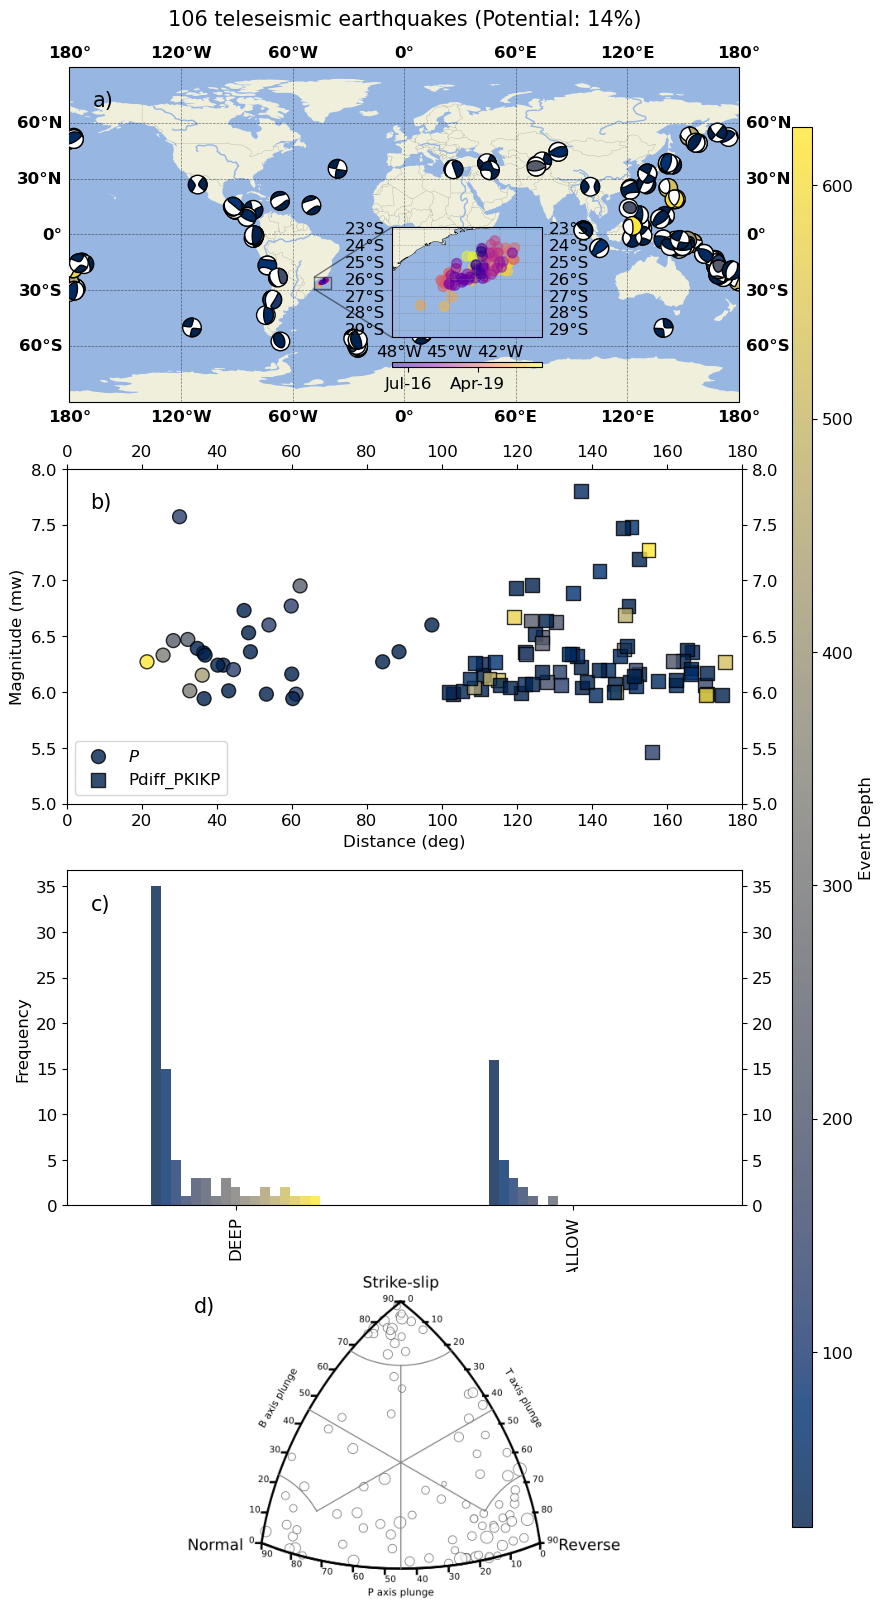

In [101]:
fig = plt.figure(figsize=(10,20))
mpl.rcParams.update({'font.size': 12})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(4,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.cividis(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider['moment_tensor'])):
    bb = beach(dataframe_events_glider['moment_tensor'].values[i], xy=(dataframe_events_glider['ev_long'].values[i], dataframe_events_glider['ev_lat'].values[i]),facecolor=hex_colors[i],width=10, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider['time_glider']]),marker='o',alpha=0.5,cmap='plasma',s=2.5,transform=proj)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(dataframe_events_glider))+' teleseismic earthquakes (Potential: '+str(round(len(dataframe_events_glider)/len(cat)*100))+'%)',fontsize=15,y=1.1)
ax.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax.transAxes,fontsize=15)


#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.45, 0.69, 0.15, 0.15],projection=proj)

h = axins.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider['time_glider']]),marker='o',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['longitude'])-abs(np.min(dataframe_glider_xml['longitude'])/30)
x2 = np.max(dataframe_glider_xml['longitude'])+abs(np.max(dataframe_glider_xml['longitude'])/30)
y1 = np.min(dataframe_glider_xml['latitude'])-abs(np.min(dataframe_glider_xml['latitude'])/30)
y2 = np.max(dataframe_glider_xml['latitude'])+abs(np.max(dataframe_glider_xml['latitude'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT 
#####################################################

ax1 = fig.add_subplot(4, 1, 2)

P_df = dataframe_events_glider[dataframe_events_glider.Phase == "SHALLOW"]
Pdiff_PKIKP_df = dataframe_events_glider[dataframe_events_glider.Phase == "DEEP"]

sc1 = ax1.scatter(P_df.distance,P_df.magnitude,marker='o',c=P_df.ev_depth_round.to_list(),s=100,cmap='cividis',edgecolors='k',alpha=0.8)
sc2 = ax1.scatter(Pdiff_PKIKP_df.distance,Pdiff_PKIKP_df.magnitude,marker='s',c=Pdiff_PKIKP_df.ev_depth_round.to_list(),s=100,cmap='cividis',edgecolors='k',alpha=0.8)

sc = [sc1,sc2]
ax1.legend(sc,["$P$","Pdiff_PKIKP"], loc='lower left',scatterpoints=1)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)

#####################################################
# Adding HISTOGRAM PLOT 
#####################################################

# ------------------------------------------------------------------------------------------------------------------------------------------
# Get colors from Plasma colormap
magma_hex_colors = ['#000004', '#1a001e', '#470b39', '#7d1e5e', '#b3314f', '#ec6e51', '#f9cb51']

ax2 = fig.add_subplot(4, 1, 3)
sc4 = pd.crosstab(dataframe_events_glider.Phase, dataframe_events_glider.ev_depth_round).plot.bar(stacked=False,cmap='cividis',alpha=0.8,ax=ax2,legend=False)
ax2.set_xlabel('Seismic Phase')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', labelrotation=90,labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='y', labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
ax3 = fig.add_subplot(4, 1, 4)
arr_img = plt.imread("/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms_potential.png")
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='d)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',fraction=0.025, shrink= 0.025)

# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_potential.png',pad_inches=0.025)


# Filtrando o banco de dados em função da análise visual dos resultados:

In [102]:
selected_events = glob.glob(FOLDER_OUTPUT+'FIGURAS/EVENT_FOCAL_MECHANISM/EVENT_MSEED_TESEISMIC_SELECTED/*/*')

In [103]:
selected_events_lst = []
for img in selected_events:
    selected_events_lst.append(img.split('/')[-1].split('.')[0].split('_')[-1])

In [104]:
selected_events_lst

['202001191658A',
 '201904121140A',
 '201701100613A',
 '202003250249A',
 '201902171435A',
 '201907111708A',
 '201907140910A',
 '201802251744A',
 '201612081738A',
 '201707261032A',
 '201706140729A',
 '202001070824A',
 '201612251422A',
 '201811111403A',
 '201611041620A',
 '201707180205A',
 '201704150819A',
 '201810290654A']

In [105]:
final_catalog = []
for i in selected_events_lst:
    for j in filtered_catalog:
        if i == j.event_descriptions[0].text:
            final_catalog.append(j)

In [106]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_final_lst = []
for evet in final_catalog:
    Exponent_ = 1
    results_final_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [107]:
file = open('earthquakes_glider_final.dat','w')
for item in results_final_lst:
	file.write(item+"\n")
file.close()

In [108]:
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_final_data.pdf earthquakes_glider_final.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
123.87 -0.15 129.4 0.782 0.262 -1.04 1.2 0.602 1.85 19.0 X Y 202001191658A SS-R
122.56 -1.85 12.0 0.248 1.62 -1.87 0.041 -0.318 0.127 20.0 X Y 201904121140A SS
122.78 4.57 621.5 -0.073 0.143 -0.07 0.071 -0.966 0.27 21.0 X Y 201701100613A N
157.87 49.11 52.6 1.96 -0.199 -1.76 0.189 -0.293 -0.815 21.0 X Y 202003250249A R
152.13 -3.33 372.2 -4.72 3.88 0.837 1.65 -0.223 0.757 19.0 X Y 201902171435A N
155.19 -4.66 493.1 -1.11 1.16 -0.054 0.386 -0.21 0.303 19.0 X Y 201907111708A N
128.13 -0.72 12.0 -0.72 7.35 -6.64 0.59 0.58 2.83 20.0 X Y 201907140910A SS
142.97 -6.29 12.0 1.69 -1.29 -0.4 1.13 -0.255 0.7 21.0 X Y 201802251744A R
161.12 -10.46 45.5 5.22 -3.57 -1.65 -1.35 -1.86 3.69 21.0 X Y 201612081738A R-SS
130.13 26.9 12.0 -0.935 0.235 0.7 0.289 0.429 0.538 19.0 X Y 201707261032A N
-92.17 14.92 72.7 -1.48 0.845 0.631 2.25 -1.83 -1.1 20.0 X Y 201706140729A N
-66.79 18.02 

0

In [109]:
 dataframe_events_glider_final = dataframe_events_glider[dataframe_events_glider['ev_ID'].isin(selected_events_lst)]

In [116]:
dataframe_events_glider_final.to_csv(FOLDER_OUTPUT+'FIGURAS/STATISTICS/table_events_selected.csv')

In [114]:
dataframe_events_glider_final.head(5)

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,time_glider,lat_glider,lon_glider,dep_glider,time_dive_info,lat_dive_info,lon_dive_info,depth_dive_info,year,ev_depth_round
25,GL.G2014..HHH.D.2020.085,G2014,DEEP,202003250249A,2020-03-25T02:49:32.100000Z,49.11,157.87,52.6,150.590614,7.48,...,2020-03-25T02:07:00.000000Z,-24.6254,-42.9124,-474.82,"[2020-03-25T02:07:00.000000Z, 2020-03-25T08:34...","[-24.6254, -24.6498, -24.724, -24.7122, -24.67...","[-42.9124, -42.8853, -42.8503, -42.8233, -42.7...","[-474.82, -468.87, -475.9, -470.61, -470.04, -...",2020,75.0
28,GL.G2012..HHH.D.2020.007,G2012,SHALLOW,202001070824A,2020-01-07T08:24:31.800000Z,18.02,-66.79,12.0,48.977281,6.36,...,2020-01-07T05:26:00.000000Z,-25.5139,-43.319,-472.97,"[2020-01-02T19:56:00.000000Z, 2020-01-02T23:56...","[-25.0276, -25.0456, -25.083, -25.126, -25.201...","[-42.3757, -42.4109, -42.4983, -42.6067, -42.8...","[-378.44, -469.82, -472.92, -474.51, -470.21, ...",2020,25.0
34,GL.G2012..HHH.D.2020.019,G2012,DEEP,202001191658A,2020-01-19T16:58:22.900000Z,-0.15,123.87,129.4,151.658103,6.2,...,2020-01-19T15:16:00.000000Z,-25.4206,-43.3376,-468.77,"[2020-01-02T19:56:00.000000Z, 2020-01-02T23:56...","[-25.0276, -25.0456, -25.083, -25.126, -25.201...","[-42.3757, -42.4109, -42.4983, -42.6067, -42.8...","[-378.44, -469.82, -472.92, -474.51, -470.21, ...",2020,150.0
40,GL.G190X..HHH.D.2019.192,G190X,DEEP,201907111708A,2019-07-11T17:08:38.800000Z,-4.66,155.19,493.1,146.580679,6.0,...,2019-07-11T15:29:00.000000Z,-24.8256,-41.1733,-419.6,"[2019-06-29T15:26:00.000000Z, 2019-06-29T15:54...","[-23.7686, -23.7741, -23.7848, -23.7933, -23.8...","[-41.1344, -41.1398, -41.1442, -41.1539, -41.1...","[-144.77, -15.66, -125.12, -123.52, -119.14, -...",2019,500.0
42,GL.G190X..HHH.D.2019.195,G190X,DEEP,201907140910A,2019-07-14T09:11:04.600000Z,-0.72,128.13,12.0,152.514159,7.19,...,2019-07-14T07:41:00.000000Z,-24.8184,-41.2338,-426.74,"[2019-06-29T15:26:00.000000Z, 2019-06-29T15:54...","[-23.7686, -23.7741, -23.7848, -23.7933, -23.8...","[-41.1344, -41.1398, -41.1442, -41.1539, -41.1...","[-144.77, -15.66, -125.12, -123.52, -119.14, -...",2019,25.0


# FIGURA FINAL com terremotos, análises estatísticas e análise do mecanismo focal

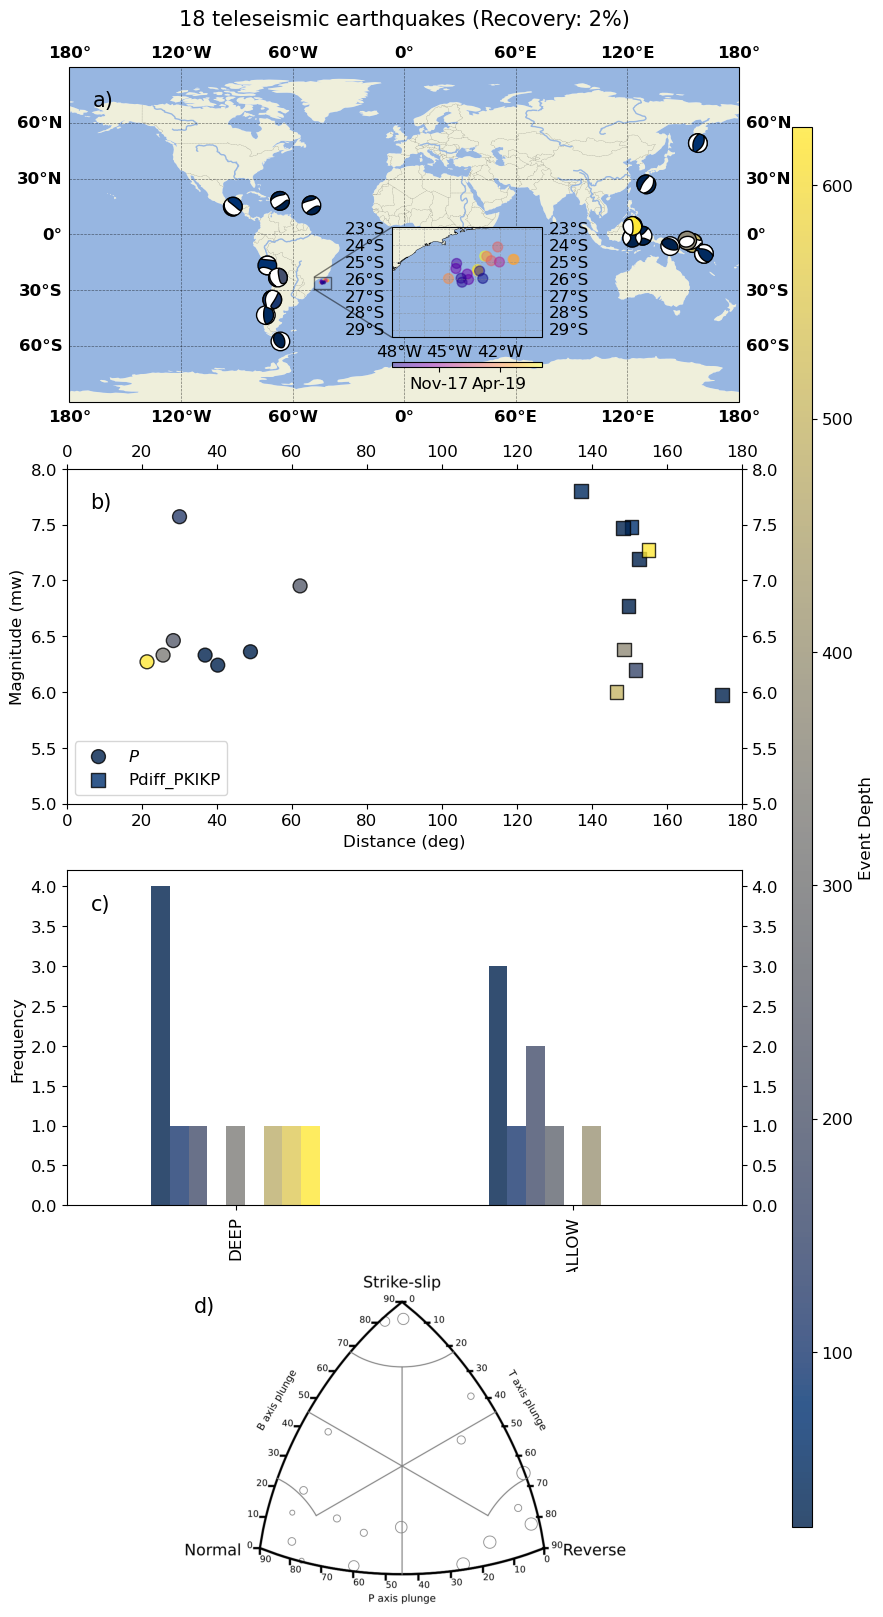

In [113]:
fig = plt.figure(figsize=(10,20))
# Definindo globalmente o tamanho da fonte
mpl.rcParams.update({'font.size': 12})
#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(4,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider_final.ev_depth_round.to_list())
max_val = max(dataframe_events_glider_final.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider_final.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.cividis(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider_final['moment_tensor'])):
    bb = beach(dataframe_events_glider_final['moment_tensor'].values[i], xy=(dataframe_events_glider_final['ev_long'].values[i], dataframe_events_glider_final['ev_lat'].values[i]),facecolor=hex_colors[i],width=10, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='o',alpha=0.5,cmap='plasma',s=2.5,transform=proj)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(dataframe_events_glider_final))+' teleseismic earthquakes (Recovery: '+str(round(len(dataframe_events_glider_final)/len(cat)*100))+'%)',fontsize=15,y=1.1)
ax.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax.transAxes,fontsize=15)


#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.45, 0.69, 0.15, 0.15],projection=proj)

h = axins.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='o',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['longitude'])-abs(np.min(dataframe_glider_xml['longitude'])/30)
x2 = np.max(dataframe_glider_xml['longitude'])+abs(np.max(dataframe_glider_xml['longitude'])/30)
y1 = np.min(dataframe_glider_xml['latitude'])-abs(np.min(dataframe_glider_xml['latitude'])/30)
y2 = np.max(dataframe_glider_xml['latitude'])+abs(np.max(dataframe_glider_xml['latitude'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT 
#####################################################

ax1 = fig.add_subplot(4, 1, 2)

P_df = dataframe_events_glider_final[dataframe_events_glider_final.Phase == 'SHALLOW']
Pdiff_PKIKP_df = dataframe_events_glider_final[dataframe_events_glider_final.Phase == 'DEEP']

sc1 = ax1.scatter(P_df.distance,P_df.magnitude,marker='o',c=P_df.ev_depth_round.to_list(),s=100,cmap='cividis',edgecolors='k',alpha=0.8)
sc2 = ax1.scatter(Pdiff_PKIKP_df.distance,Pdiff_PKIKP_df.magnitude,marker='s',c=Pdiff_PKIKP_df.ev_depth_round.to_list(),s=100,cmap='cividis',edgecolors='k',alpha=0.8)

sc = [sc1,sc2]
ax1.legend(sc,["$P$","Pdiff_PKIKP"], loc='lower left',scatterpoints=1)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)

#####################################################
# Adding HISTOGRAM PLOT 
#####################################################

# ------------------------------------------------------------------------------------------------------------------------------------------
# Get colors from Plasma colormap
magma_hex_colors = ['#000004', '#1a001e', '#470b39', '#7d1e5e', '#b3314f', '#ec6e51', '#f9cb51']

ax2 = fig.add_subplot(4, 1, 3)
sc4 = pd.crosstab(dataframe_events_glider_final.Phase, dataframe_events_glider_final.ev_depth_round).plot.bar(stacked=False,cmap='cividis',alpha=0.8,ax=ax2,legend=False)
ax2.set_xlabel('Seismic Phase')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', labelrotation=90,labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='y', labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
ax3 = fig.add_subplot(4, 1, 4)
arr_img = plt.imread("/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms.png")
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='d)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',fraction=0.025, shrink= 0.025)

# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_recorded.png',pad_inches=0.02,dpi=200)
